In [1]:
from keras.applications import VGG16

'''
VGG16 is a model trained with ImageNet dataset.
It has 16 convolutional base layers and 3 Densly connected layers.

Train the new model by using convolutional base layers of VGG16.
And connect new densly connected layers to classify images into cats and dogs.
'''

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
# Case I. Features from VGG16 without augmentation sample images.

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

dataset_dir = '/home/guhwanbae/workspace/machine-learning/resource/cats-and-dogs-small'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

In [4]:
def extract_featrues(directory, sample_count, model, input_shape, datagen, batch_size):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=input_shape,
        batch_size=batch_size,
        class_mode='binary')
    for idx, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = model.predict(inputs_batch)
        first = idx * batch_size
        last = (idx+1) * batch_size
        features[first:last] = features_batch
        labels[first:last] = labels_batch
        if last >= sample_count:
            break
    return features, labels    

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
input_shape = (150, 150)
batch_size = 20

train_features, train_labels = extract_featrues(train_dir, sample_count=2000,
                                                model=conv_base, input_shape=input_shape,
                                                datagen=datagen, batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [6]:
validation_features, validation_labels = extract_featrues(validation_dir, sample_count=1000,
                                                          model=conv_base, input_shape=input_shape,
                                                          datagen=datagen, batch_size=batch_size)

Found 1000 images belonging to 2 classes.


In [7]:
test_features, test_labels = extract_featrues(test_dir, sample_count=1000,
                                              model=conv_base, input_shape=input_shape,
                                              datagen=datagen, batch_size=batch_size)

Found 1000 images belonging to 2 classes.


In [9]:
array_save_path = './features_from_vgg16'
np.savez(array_save_path,
         train_featrues=train_features,
         train_labels=train_labels,
         validation_features=validation_features,
         validation_labels=validation_labels,
         test_features=test_features,
         test_labels=test_labels)

In [10]:
'''
Reshape features passed convolutional layers to input to densely connected layers.
Input shape of densely connected layers is 8192 flatten, (4, 4, 512) to (8192,).
'''

dense_layer_input_shape = 4*4*512
train_features = train_features.reshape((2000, dense_layer_input_shape))
validation_features = validation_features.reshape((1000, dense_layer_input_shape))
test_featrues = test_features.reshape((1000, dense_layer_input_shape))

In [11]:
'''
Classifier
Add densely connected layers to classify binary labels, cats and dogs,
from features passed through VGG16 convoludtional base layers.
To regularize add a dropout layer.
'''

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=dense_layer_input_shape))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [13]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 947us/step - loss: 0.6036 - acc: 0.6710 - val_loss: 0.4391 - val_acc: 0.8270
Epoch 2/30
2000/2000 [==============================] - 2s 830us/step - loss: 0.4291 - acc: 0.8115 - val_loss: 0.3756 - val_acc: 0.8450
Epoch 3/30
2000/2000 [==============================] - 2s 826us/step - loss: 0.3601 - acc: 0.8445 - val_loss: 0.3209 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 2s 849us/step - loss: 0.3086 - acc: 0.8795 - val_loss: 0.2989 - val_acc: 0.8880
Epoch 5/30
2000/2000 [==============================] - 2s 834us/step - loss: 0.2871 - acc: 0.8865 - val_loss: 0.2972 - val_acc: 0.8720
Epoch 6/30
2000/2000 [==============================] - 2s 903us/step - loss: 0.2643 - acc: 0.8940 - val_loss: 0.2689 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 2s 849us/step - loss: 0.2499 - acc: 0.9005 - val_loss: 0.2622 - val_acc: 0.8930


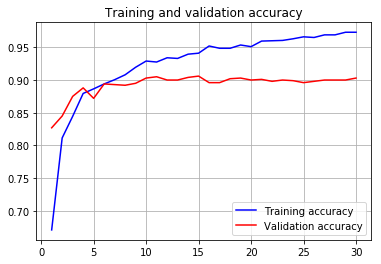

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(len(acc)) + 1

plt.figure('Accuracy')
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='b', label='Training accuracy')
plt.plot(epochs, val_acc, color='r', label='Validation accuracy')
plt.legend()
plt.grid()
plt.show()

# Validation accuracy is saturated about 90% after 10 epochs.

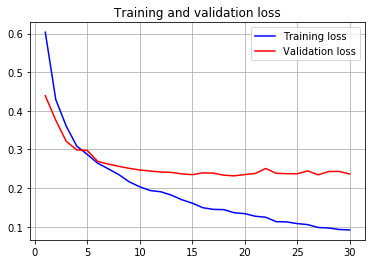

'\nEven with a drop-out layer, model is quickly overfitting after first iteration of training.\nBecause features are obtained directly from VGG16 model not trained augmented sample images.\n'

In [17]:
plt.figure('Loss')
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='b', label='Training loss')
plt.plot(epochs, val_loss, color='r', label='Validation loss')
plt.legend()
plt.grid()
plt.show()

'''
Even with a drop-out layer, model is quickly overfitting after first iteration of training.
Because features are obtained directly from VGG16 model not trained augmented sample images.
'''

In [18]:
model.save('dogs_and_cats_vgg16_direct_features_1.h5')